# Modelo de Análisis de precios de acciones a partir de un modelo LSTM

Lucho Nov | 2024

# Explicación del modelo de forma breve

(Modelo de ejemplo de miles de fuentes de información y la autoría, no es en su totalidad, propia)

## Modelo LSTM para Predicción de Acciones

Los modelos de memoria a largo corto plazo (LSTM) son un tipo de red neuronal recurrente (RNN) capaces de aprender
dependencias a largo plazo en secuencias de datos.

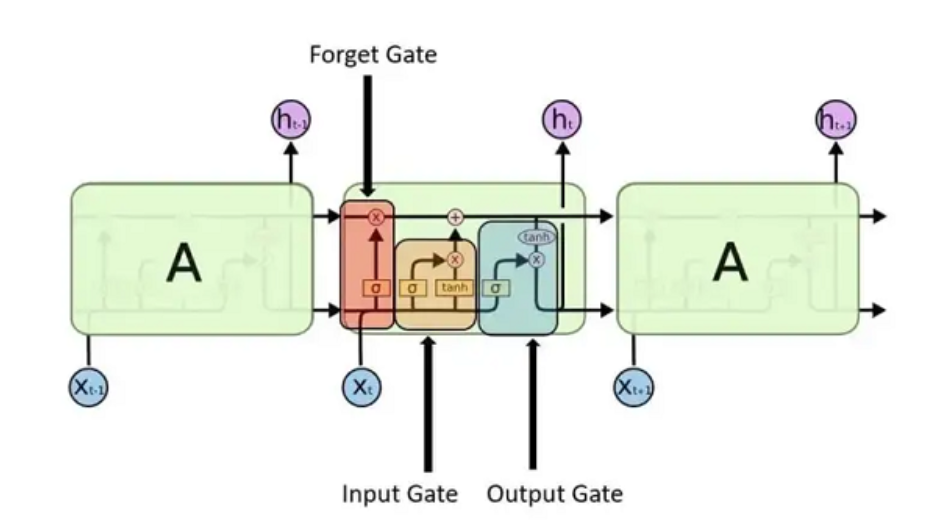

## Formulas de LTSM

- **Puerta de Olvido:**

  $$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$

- **Puerta de Entrada:**

  $$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$

- **Candidata de la Celda:**

  $$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$

- **Estado de la Celda:**

  $$C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$$

- **Puerta de Salida:**

  $$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$

- **Estado Oculto:**

  $$h_t = o_t \odot \tanh(C_t)$$

Donde:
- \( x_t \) es la entrada en el tiempo \( t \).
- \( h_t \) es el estado oculto.
- \( C_t \) es la memoria de la celda.
- \( W \) y \( b \) son los pesos y sesgos aprendidos.
- \( \sigma \) es la función sigmoide y \( \tanh \) es la tangente hiperbólica.

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
np.random.seed(3)

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

## Import dataset

In [2]:
df=pd.read_csv('apple_stock_data_2006_2023.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-01-03,2.585000,2.669643,2.580357,2.669643,2.249496,807234400
1,2006-01-04,2.683214,2.713571,2.660714,2.677500,2.256118,619603600
2,2006-01-05,2.672500,2.675000,2.633929,2.656429,2.238362,449422400
3,2006-01-06,2.687500,2.739286,2.662500,2.725000,2.296141,704457600
4,2006-01-09,2.740357,2.757143,2.705000,2.716071,2.288617,675040800


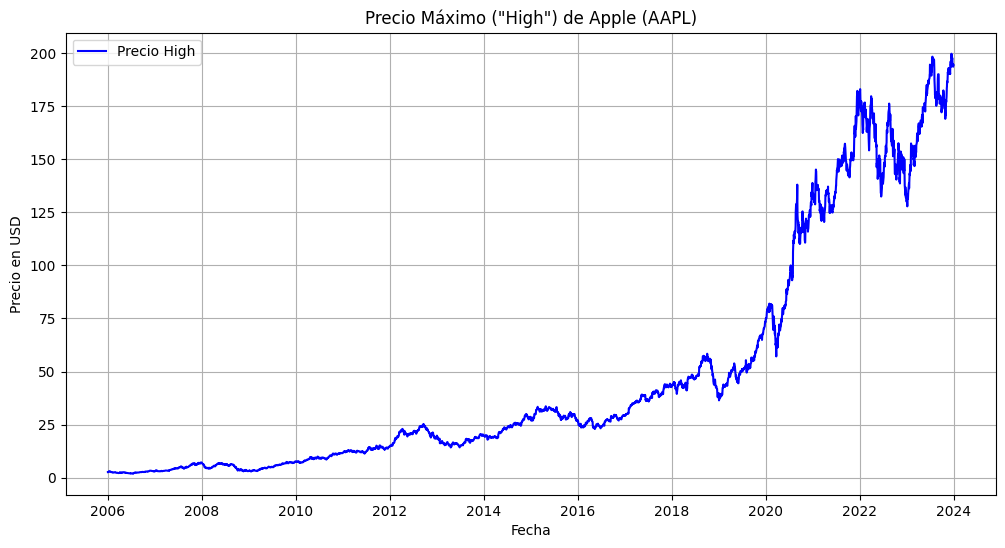

In [3]:
#Componemos el set de entrenamiento y el de test para analizar cómo de bueno es el mo
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
train_set = df.loc[df.index < '2017', ['High']].values
test_set = df.loc[df.index >= '2023', ['High']].values

#Debemos de escalar los datos del 0 al 1 para poder analizar de forma correcta el mod

escalar=MinMaxScaler(feature_range=(0,1))
train_set_scale=escalar.fit_transform(train_set)
test_set_scale=escalar.transform(test_set)

# Graficar el precio máximo ("High")
plt.figure(figsize=(12,6))
plt.plot(df.index, df['High'], label='Precio High', color='blue')

# Personalización del gráfico
plt.title('Precio Máximo ("High") de Apple (AAPL)')
plt.xlabel('Fecha')
plt.ylabel('Precio en USD')
plt.legend()
plt.grid(True)

# Mostrar gráfico
plt.show()

In [4]:
steps=100
Xtrain=[]
Ytrain=[]
a=len(train_set_scale)

for j in range(steps,a):
    Xtrain.append(train_set_scale[j-steps:j,0])
    Ytrain.append(train_set_scale[j,0])

Xtrain,Ytrain=np.array(Xtrain),np.array(Ytrain)

#Debemos de transponer el vector que acabamos de crear para introducirlo en el modelo

Xtrain=np.reshape(Xtrain,(Xtrain.shape[0],Xtrain.shape[1],1))

In [5]:
#Definimos la dimensión del modelo
dim_salida=1
dim_entrada=Xtrain.shape[1],1
#Definimos el número de neuronas que queremos establecer en nuestro modelo
neuronas=100

#Definimos el modelo
m=Sequential()
m = Sequential([
    Input(shape=dim_entrada),
    LSTM(units=neuronas),
    Dense(units=dim_salida)
])


#Compilamos el modelo
m.compile(optimizer='rmsprop',loss='mean_squared_error')

#Entrenamos el modelo
m.fit(Xtrain,Ytrain,epochs=4,batch_size=32)

Epoch 1/4
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0221
Epoch 2/4
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0012
Epoch 3/4
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0011
Epoch 4/4
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 8.4371e-04


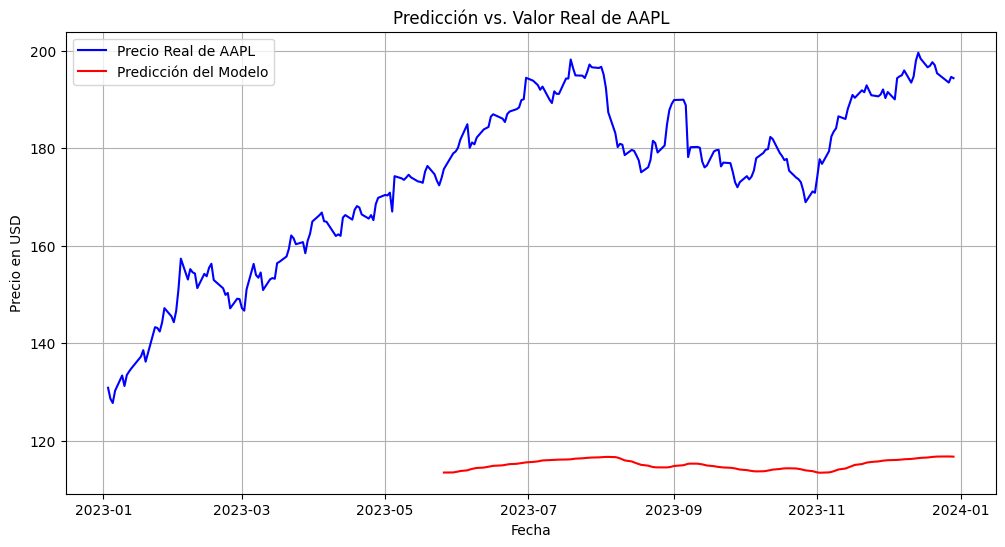

In [6]:
X_test=test_set_scale
x_test = []

for i in range(steps,len(X_test)):
    x_test.append(X_test[i-steps:i,0])

x_test = np.array(x_test, dtype=np.float32) 
x_test = np.reshape(x_test, (x_test.shape[0], 100, 1))

x_test_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)

#Comprobación del modelo predicciones
prediccion = m.predict_on_batch(x_test)

#Invertimos la transformación realizada
prediccion = escalar.inverse_transform(prediccion)
real = escalar.inverse_transform(test_set_scale) # Valores reales


# Graficar los valores reales vs. predichos
plt.figure(figsize=(12,6))
plt.plot(df.index[-len(real):], real, color='blue', label='Precio Real de AAPL')
plt.plot(df.index[-len(prediccion):], prediccion, color='red', label='Predicción del Modelo')

         
# Personalización del gráfico
plt.title('Predicción vs. Valor Real de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Precio en USD')
plt.legend()
plt.grid(True)
# Mostrar el gráfico
plt.show()